# Tutorial：4
- 使用フレームワーク : deap
- 選択手法 : NSGA-Ⅲ
- 設計変数 : 5個
  - 連続値 : 3個
  - 離散値 : 2個
- 目的変数 : 2個
- 制約条件 : 2パターン
  1. min,max
  2. 連続値の変数の和に制約あり(範囲指定)

## 習得してもらうこと
- 連続値の変数の和に制約あり

## 実施内容
 - Part0. 取り扱う問題設定

 - Patr1: モジュールのimport 

 - Part2: 評価関数の作成
   - 目的関数の設計
   - ペナルティ関数の導入


 - Part3: 遺伝的アルゴリズムの設計
   - 遺伝的アルゴリズムにおける個体の表現
   - 遺伝子操作関数の設定
     - 交叉
     - 突然変異
   - 解の選択手法の設定


 - Part4: 最適化計算の実行
   - 初期状態の設定
   - 遺伝的最適化計算の実行  


 - Part5. 結果の確認
   - 初期世代と最終世代の目的関数の値を確認
   - 制約条件を満たした値であるか確認
   - ハイパーボリューム

# Part0. 取り扱う問題設定

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + X^2 + Y \\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 + 4(C + 2)^2 + X + 4Y^2 \\
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0 & \leqq  B  \leqq 3 \\
& & -2 & \leqq C \leqq 3 \\
& & X &\in \{0,1\}\\
& & Y &\in \{-2,-1,0,1\}\\
& & 2 & \leqq A + B + Y \leqq 5
\end{align*}
$

# Part1. モジュールのimport

In [1]:
%load_ext lab_black

In [2]:
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deap import base, creator, tools
from deap.algorithms import varAnd
from deap.benchmarks.tools import hypervolume

from itertools import repeat

# Part2. 評価関数の作成

#### 進化計算における評価関数は二つの要素からなります

- 最適解を見つけたい目的関数
- 設計変数が制約を満たさない時に淘汰されるように設定するペナルティ関数

### 目的関数
- 今回は5つの設計変数A,B,C(連続値),X,Y(離散値)を使って目的変数のf1, f2 を多目的最適化する

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + X^2 + Y\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 + 4(C + 2)^2 + X + 4Y^2
\end{align*}
$


In [3]:
# 評価関数
def objectfunction(individual):
    """
    individual(list): 個体の設計変数を格納するlist
    """
    # 教材用として、A, B, C, X, Yの変数を作成
    A = individual[0]
    B = individual[1]
    C = individual[2]
    X = individual[3]
    Y = individual[4]

    f1 = 4 * A ** 2 + 4 * B ** 2 + 4 * C ** 2 + X ** 2 + Y
    f2 = (A - 5) ** 2 + (B - 5) ** 2 + 4 * (C + 2) ** 2 + X + 4 * Y ** 2
    return f1, f2

### ペナルティ関数

#### 本計算では連続値が制約条件の範囲外にある場合、次世代に個体が残らないようにペナルティ関数を導入します

$
\begin{align*}
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0 & \leqq  B  \leqq 3 \\
& & -2 & \leqq C \leqq 3 \\
& & X &\in \{0,1\}\\
& & Y &\in \{-2,-1,0,1\}\\
& & 2 & \leqq A + B + Y \leqq 5
\end{align*}
$

In [4]:
# ペナルティ関数で判定したい制約条件のリスト
# 教材用にこちらで定義していますが。後ほど登場する「generator_config」から作れるようにした方が良いです
cases = [
    {
        "type": "minmax",
        "case": {
            0: {"min": 0, "max": 5},  # 設計変数:A
            1: {"min": 0, "max": 3},  # 設計変数:B
            2: {"min": -2, "max": 3},  # 設計変数:C
        },
    },
    {
        "type": "is_disc",
        "case": {
            3: {"values": [0, 1]},  # 設計変数X
            4: {"values": [-2, -1, 0, 1]},  # 設計変数Y
        },
    },
    {"type": "total_minmax", "case": {(0, 1, 4): {"min": 2, "max": 5}}},
]

#### 複数変数のパターン組み合わせに関する制約を満たしているかをjudge_total_minmaxという関数でチェックします

In [5]:
# ペナルティ関数で使用する関数
# 可能範囲以内(連続値)
def judge_minmax(individual, case):
    for k, v in case.items():
        if not float(v["min"]) <= individual[int(k)] <= v["max"]:
            return False
    return True


# 可能範囲以内(離散値)
def judge_disc(individual, case):
    for k, v in case.items():
        if not (individual[int(k)] in v["values"]):
            return False
    return True


# 複数変数のパターン制約
def judge_total_minmax(individual, case):
    for idxs, v in case.items():
        total = 0
        for idx in idxs:
            total += individual[int(idx)]
        if not float(v["min"]) <= total <= float(v["max"]):
            return False
    return True


# ペナルティ関数用の条件判定関数 - 他の条件が出来た時にfor文内に追記することで対応可
def judge(individual, cases):
    """
    individual(list): 個体の設計変数を格納するlist
    cases(list): 判定したい条件のlist(各要素はdict型)
    """
    for case in cases:
        if case["type"] == "minmax":
            if not judge_minmax(individual, case["case"]):
                return False
        if case["type"] == "is_disc":
            if not judge_disc(individual, case["case"]):
                return False
        if case["type"] == "total_minmax":
            if not judge_total_minmax(individual, case["case"]):
                return False
    return True

#### 評価関数&ペナルティ関数の導入

In [6]:
# ペナルティ関数の罰則値(適応度)
distance = (1000, 1000)

# 評価関数を作成
toolbox = base.Toolbox()
toolbox.register("evaluate", objectfunction)
toolbox.register("feasible", judge, cases=cases)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, delta=distance))

# Part.3 遺伝的アルゴリズムの設計

## 遺伝的アルゴリズムにおける個体の表現

In [7]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

### 制約条件を満たした初期値設定

$
\begin{align*}
&s.t.& 0 & \leqq  A  \leqq 5 \\
& & 0 & \leqq  B  \leqq 3 \\
& & -2 & \leqq C \leqq 3 \\
& & X &\in \{0,1\}\\
& & Y &\in \{-2,-1,0,1\}\\
& & 2 & \leqq A + B + Y \leqq 5
\end{align*}
$

In [8]:
# 個体を作成する制約条件を記載したのdictを作成
generator_config = {
    # 使用するカラム
    "columns": ["A", "B", "C", "X", "Y"],
    # 各連続値の作成条件
    "variables": {
        "A": {"type": "real", "values": {"min": 0, "max": 5}},
        "B": {"type": "real", "values": {"min": 0, "max": 3}},
        "C": {"type": "real", "values": {"min": -2, "max": 3}},
        "X": {"type": "discrete", "values": [0, 1]},
        "Y": {"type": "discrete", "values": [-2, -1, 0, 1]},
    },
    # 複数の変数の和の条件
    "constrains": [
        {"type": "real", "columns": ["A", "B", "Y"], "values": {"min": 2, "max": 5}}
    ],
    # 突然変異で使うカラムの指定
    "mutate_real_col": ["A", "B", "C"],
    "mutate_discrete_col": ["X", "Y"],
    # 和の制約を追加するカラム
    "limited_sum_cols": ["A", "B", "Y"],
    # 交叉で使用する連続値のカラム
    "independent_real_col": ["A", "B", "C"],
    # 交叉で使用する離散値のカラム
    "independent_discrete_col": ["X", "Y"],
}

## 初期サンプルの生成関数
####  generator_configから初期値生成

In [9]:
# 個体を生成する関数
def generator(generator_config):
    """
    generator_config (dict): 個体を作成する制約条件が記載されたdict
    """

    var = generator_config["variables"]
    constrains = generator_config["constrains"]
    variables = {}
    for k, v in var.items():
        # 離散値のサンプル生成
        if v["type"] == "discrete":
            variables[k] = random.choice(v["values"])
        # 連続値のサンプル生成
        elif v["type"] == "real":
            variables[k] = random.uniform(v["values"]["min"], v["values"]["max"])

    return [variables[col] for col in generator_config["columns"]]


# [お試し]このように作成されます
# generator(generator_config)

#### 初期サンプルを生成

In [10]:
toolbox.register("generator", generator, generator_config)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


## 遺伝子操作関数

#### 進化計算で重要な役割を持つ遺伝子操作を行う関数を生成

- deap公式の交叉・突然変異の関数を使う

### 交叉

1. 交叉関数 : `cxTwoPoint` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint)　[github](https://github.com/DEAP/deap/blob/master/deap/tools/crossover.py)

In [11]:
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

### 突然変異

2. 変異関数 : `mutPolynomialBounded` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded)　[github](https://github.com/DEAP/deap/blob/master/deap/tools/mutation.py)


In [12]:
# 突然変異用のdict作成する関数
def muconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """
    cols = constrain_dict["columns"]  # 現状のカラム

    mur = constrain_dict["mutate_real_col"]  # 突然変異するカラム(連続値)
    mud = constrain_dict["mutate_discrete_col"]  # 突然変異するカラム(離散値)

    mu_real_index = [cols.index(c) for c in cols if c in mur]  # 連続値のindex
    mu_discrete_index = [cols.index(c) for c in cols if c in mud]  # 離散値のindex
    mu_discrete_values = [
        constrain_dict["variables"][col]["values"] for col in mud if col in cols
    ]  # 離散値変数が取りうる値

    mu_low = [
        constrain_dict["variables"][col]["values"]["min"] for col in mur if col in cols
    ]  # 連続値の下限

    mu_up = [
        constrain_dict["variables"][col]["values"]["max"] for col in mur if col in cols
    ]  # 連続値の上限

    for mi, ma in zip(mu_low, mu_up):  # 上限と下限が逆転していないか？イコールになっていないか？
        if not mi <= ma:
            raise MutateionError("some low values higher than ups values")

    mucfg = {}
    mucfg["real_indexs"] = mu_real_index  # 連続値に対する設計変数のindex
    mucfg["discrete_indexs"] = mu_discrete_index  # 離散値に対する設計変数のindex
    mucfg["discrete_values"] = mu_discrete_values  # 離散値に対する設計変数が取りうる値
    mucfg["lows"] = mu_low  # 連続値に対する設計変数の最小値
    mucfg["ups"] = mu_up  # 連続値に対する設計変数の最大値

    return mucfg

In [13]:
# 突然変異用のdice作成
mucfg = muconfig(generator_config)
mucfg

{'real_indexs': [0, 1, 2],
 'discrete_indexs': [3, 4],
 'discrete_values': [[0, 1], [-2, -1, 0, 1]],
 'lows': [0, 0, -2],
 'ups': [5, 3, 3]}

#### 変異の処理も制約を満たすように修正

In [14]:
# 各変数ごとに分けて突然変異をするための関数
def mutation(
    individual,
    realmut,
    real_indexs,
    discrete_indexs,
    discrete_values,
    lows,
    ups,
    indpb=None,
):
    """
    individual (list): 個体のlist
    realmut(function): 親個体, lows, ups, indpbを引数にとる変異関数
    real_indexs(list): 設計変数の内、連続値であるもののindexからなるlist
    discrete_indexs(list): 設計変数の内、離散値であるもののindexからなるlist
    discrete_values(list): 離散値の設計変数が取りうる値
    lows (list): 連続値の最小値
    ups(list) : 連続値の最大値
    indpb(float): 各変数に対して変異を行うか否かの確率、デフォルト値はNone. 0 <= indpb <= 1.
    """

    if not isinstance(real_indexs, list):
        raise CrossoverError(
            f'argment "real_indexs" must be list but inputed {type(real_indexs)}'
        )
    if not isinstance(discrete_indexs, list):
        raise MutateionError(
            'argment "real_indexs" must be list but inputed' f" {type(discrete_indexs)}"
        )

    if not isinstance(lows, list):
        raise MutateionError(f"argment lows must be  list but {type(lows)}")
    if not isinstance(ups, list):
        raise MutateionError(f"argment ups must be  list but {type(ups)}")

    if not (len(real_indexs) == len(lows) and len(real_indexs) == len(ups)):
        raise MutateionError("not match lows, ups ,or real_indexs length")

    if indpb is None:
        indpb = 1 / (len(real_indexs) + len(discrete_indexs))

    # 連続値の染色体を抽出
    real_chromosome = [individual[i] for i in real_indexs]
    # 変異を実施
    real_chromosome = realmut(real_chromosome, low=lows, up=ups, indpb=indpb)[0]
    for i, r in zip(real_indexs, real_chromosome):
        individual[i] = r

    # 離散値の染色体を抽出
    discrete_chromosome = [individual[i] for i in discrete_indexs]
    # 変異を実施
    discrete_chromosome = muchoice(discrete_chromosome, discrete_values, indpb=indpb)[0]
    # 染色体の書き換え
    for i, d in zip(discrete_indexs, discrete_chromosome):
        individual[i] = d

    return (individual,)

#### 離散値用の変異処理

In [15]:
def muchoice(individual, patterns, indpb):
    """離散値、ダミー変数、組み合わせ規定で設定されている各々の固有パターンから変異を行います。

    変数ごと与えられたパターンのいずれかに確率的に変異します。
    Args:
        individual(list):有限パターンの変数を持つlist
        patterns(list):変数ごと取りうるユニークな値を格納
        indpb(float):変異確率
    Returns:
        tuple:indvidualを書き換えたものをtupleで返します
    Examples:
        >>> indivudual = [0, 1, 1]
        >>> patterns = [[0, 1], [0, 1, 1.3], [1]]
        >>> muchoice(individual, patterns, 0.3)
        [0, 1.3, 1] # 確率によって値の変異
    """

    for i, comb in enumerate(patterns):
        if random.random() < indpb:
            individual[i] = random.choice(comb)

    return (individual,)

In [16]:
# toolsにある突然変異関数を使用する(今回は一部バグ修正したものを自作関数として使用)
def mutPolynomialBounded(individual, eta, low, up, indpb):
    """
    多項式変異(deap.tools.mutPolynomialBounded)
    (https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded))
    を改変し、複素数が出現するエラーが起きないようにしたもの。

    args:
        individual(list): 1個体の各成分からなるlist
        eta(float): 混雑度
        low(float): 連続値の最小値
        up(float): 連続値の最大値
        indpb(float): 突然変異の起こる確率
    Returns:
        tuple: individualを書き換えたもの
    """

    try:
        from collections.abc import Sequence
    except ImportError:
        from collections import Sequence

    size = len(individual)
    if not isinstance(low, Sequence):
        low = repeat(low, size)
    elif len(low) < size:
        raise IndexError(
            "low must be at least the size of individual: %d < %d" % (len(low), size)
        )
    if not isinstance(up, Sequence):
        up = repeat(up, size)
    elif len(up) < size:
        raise IndexError(
            "up must be at least the size of individual: %d < %d" % (len(up), size)
        )

    for i, xl, xu in zip(range(size), low, up):
        # 突然変異を起こすか？
        if random.random() <= indpb:
            x = individual[i]
            delta_1 = (x - xl) / (xu - xl)  # (値 - 下限) / (上限 - 下限)
            delta_2 = (xu - x) / (xu - xl)  # (上限 - 値) / (上限 - 下限)
            rand = random.random()
            mut_pow = abs(1.0 / (eta + 1.0))  # 1 / (混雑度 + 1)
            sign_mut_pow = 1 if 1.0 / (eta + 1.0) >= 0 else -1
            # xyを非負の数とすることで、以下の xy ** (eta + 1), val ** mut_pow部分で虚数が発生しないようにする
            if rand < 0.5:
                xy = max(1.0 - delta_1, 0)
                val = 2.0 * rand + (1.0 - 2.0 * rand) * xy ** (eta + 1)
                delta_q = (val ** mut_pow) - 1.0
            else:
                xy = max(1.0 - delta_2, 0)
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * xy ** (eta + 1)
                delta_q = 1.0 - (val ** mut_pow)

            x = x + delta_q * (xu - xl)
            x = min(max(x, xl), xu)  # 上限と下限を超えてないか確認。超えた場合は、引っかかった方の値に
            individual[i] = x
    return (individual,)

In [17]:
realmut = partial(mutPolynomialBounded, eta=20)

# 突然変異を行う関数"mutate"を登録}
toolbox.register("mutate", mutation, realmut=realmut, **mucfg)

## 引き戻し法の実装
複数変数の和に制約がある場合、交叉or突然変異によって制約条件を満たさなくなってしまう個体が出現する可能性がある。

この時、対象となる変数を調整し、制約条件を成立する操作を行う。

In [18]:
# 離散値は係数をかけることによる引き戻しの後に、定義域に含まれるように修正を行う。
def get_nearest_value(list_, num):
    """
    リストからある値に最も近い値を返却する関数。
    """
    # リスト要素と対象値の差分を計算し最小値のインデックスを取得
    idx = np.abs(np.asarray(list_) - num).argmin()
    return list_[idx]

In [19]:
def pullback_method(individuals, conditions, epsilon=0.1):
    """和が一定で規定される変数の引き戻し法を行う
    Args:
        individuals (list): 1個体
        conditions (list): 制約条件のlist
    Returns:
        list: 制約条件に合わせて要素を修正した個体
    Examples:
        制約条件のlistは以下のような要素で構成されている::
            {'columns': [1, 2, 5], 'value': {'min': 2, 'max': 5}, ...}
    Note:
        この関数は引数にとる元の変数の値を書き換える。
    """
    for condition_dict in conditions:
        # 要素を変更する割合を求める.
        target_condition_values = sum(
            [individuals[idx] for idx in condition_dict["index"]]
        )
        if target_condition_values < condition_dict["values"]["min"]:
            ratio = condition_dict["values"]["min"] / (
                target_condition_values + epsilon
            )
        elif target_condition_values > condition_dict["values"]["max"]:
            ratio = condition_dict["values"]["max"] / (
                target_condition_values + epsilon
            )
        else:
            continue
        # 該当する要素を変更する.
        for idx in condition_dict["index"]:
            # 離散値が制約に含まれる場合を考慮して、係数をより小さめにする
            individuals[idx] = individuals[idx] * (ratio - epsilon)
            # 離散値が定義域に含まれるように修正
            if idx in condition_dict["discrete_index"]:
                individuals[idx] = get_nearest_value(
                    condition_dict["discrete_values"][
                        int(
                            np.where(idx == np.array(condition_dict["discrete_index"]))[
                                0
                            ]
                        )
                    ],
                    individuals[idx],
                )

    return individuals

In [20]:
# 引き戻し法の実装
cols = generator_config["columns"]
# 和一定制約の引き戻し関数の定義
sums = [
    {
        "index": [cols.index(col) for col in constrain["columns"]],
        "values": constrain["values"],
        "discrete_index": [
            cols.index(col)
            for col in constrain["columns"]
            if col in generator_config["independent_discrete_col"]
        ],
        "discrete_values": [
            generator_config["variables"][col]["values"]
            for col in constrain["columns"]
            if col in generator_config["independent_discrete_col"]
        ],
    }
    for constrain in generator_config["constrains"]
]
toolbox.register("pullback", pullback_method, conditions=sums)

## 解の選択（世代交代）手法

#### 今回は、NSGAⅢの選択手法を用います

- [selNSGA3について_deap公式](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA3)
- [selNSGA3の動作ついて_github](https://github.com/DEAP/deap/blob/master/deap/tools/emo.py '個体選択')

In [21]:
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA3)

# Part.4 最適化計算の実行

#### 初期状態の設定

- 初期サンプル（第一世代）の生成
- 適合度割当

In [22]:
random.seed(1)

NGEN = 50  # 繰り返し世代数
MU = 100  # 集団内の個体数
CXPB = 0.9  # 交叉率
MUTPB = 0.9  # 変異率

# 第一世代の生成
pop = toolbox.population(n=MU)
pop = list(toolbox.map(toolbox.pullback, pop))  # 和一定制約について引き戻し
pop_init = pop[:]

invalid_ind = []
for ind in pop:
    if not ind.fitness.valid:
        invalid_ind.append(ind)

fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
pop = toolbox.select(pop, len(pop), tools.uniform_reference_points(nobj=2, p=12))

#### 最適計算の実行


In [23]:
for gen in range(2, NGEN + 1):
    # 子母集団生成
    offspring = varAnd(pop, toolbox, CXPB, MUTPB)
    # 引き戻し法
    offspring = list(toolbox.map(toolbox.pullback, offspring))  # 和一定制約
    # 適合度計算
    fitnesses = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # 次世代選択
    pop = toolbox.select(
        pop + offspring, len(pop), tools.uniform_reference_points(nobj=2, p=12)
    )

# Part5. 結果の確認

## 初期世代と最終世代の目的関数の値を確認
$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + 4C^2 + X^2 + Y\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 + 4(C + 2)^2 + X + 4Y^2
\end{align*}
$


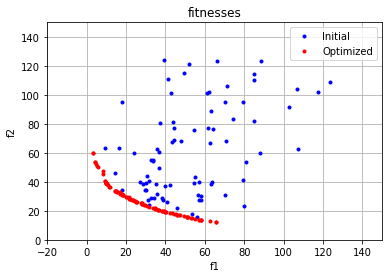

In [24]:
# 目的関数の値を確認
fitnesses_init = np.array(
    [list(pop_init[i].fitness.values) for i in range(len(pop_init))]
)
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
# グラフで確認
plt.plot(fitnesses_init[:, 0], fitnesses_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(fitnesses[:, 0], fitnesses[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("fitnesses")
# 初期の例外値が残っているのでグラフ範囲を指定
plt.xlim(-20, 150)
plt.ylim(0, 150)
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)

#### ハイパーボリュームの計算

In [25]:
# 最終世代のハイパーボリュームを出力
print("Final population hypervolume is %f" % hypervolume(pop, [200.0, 100.0]))

Final population hypervolume is 16413.672171


### 最終世代の設計変数と各適応度をデータフレームで確認

In [26]:
design = pd.DataFrame(pop).rename(
    columns={0: "A", 1: "B", 2: "C", 3: "X", 4: "Y"}
)  # 設計変数
goal = pd.DataFrame(fitnesses).rename(columns={0: "f1", 1: "f2"})  # 適応度
pd.concat([design, goal], axis=1)

,A,B,C,X,Y,f1,f2
0,1.494632,1.273086,-1.305686,0,0,22.237952,28.105783
1,1.494632,1.612477,-1.271590,0,0,25.803791,25.885242
2,2.196865,2.115269,-1.416306,0,0,45.226002,17.542035
3,1.298110,1.152005,-1.271590,0,0,18.516580,30.633384
4,2.546788,2.441133,-1.981158,0,0,65.480981,12.567472
...,...,...,...,...,...,...,...
95,1.339648,1.679753,-1.541178,0,0,27.965819,25.264291
96,0.951090,1.074365,-0.625515,0,0,9.800401,39.361122
97,2.303776,2.338698,-1.463623,0,0,51.676346,15.502951
98,2.546350,2.365853,-1.493144,0,0,57.242543,13.986743


#### 補足: 制約条件を満たしているか確認

In [27]:
pd.concat([design, goal], axis=1).apply(lambda x: 2 <= x[0] + x[1] + x[4] <= 5, axis=1)

0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Length: 100, dtype: bool

In [28]:
pd.concat([design, goal], axis=1).apply(
    lambda x: 2 <= x[0] + x[1] + x[4] <= 5, axis=1
).sum()

100

#### テスト: 自作変異関数の挙動確認
確認すること: 虚数によるエラーが発生しない

In [29]:
random.seed(2021)
for i in range(100000):
    ind = generator(generator_config)
    ind = toolbox.mutate(ind)